In [1]:
# installing 3rd party libraries

# !pip install pandas-profiling
# !pip install tsfresh
# !pip install statsmodels

# Guideline


In this experiment, we use time series analysis technique to decompose our data into 3 components like the below:

1. Trend (T)
2. Seasonility (S)
3. Residual (R)

Once we need to get a statinory dataset before performing Time Series Analysis (TSA) flawlessly beacuse it would be easy making a predicition over a stationary dataset since it would already satisfy the preoperties of `Normal Distribution` in terms of `mean` and `variance`, roughly. So, we need to delve into the raw dataset by applying some EDA techniques to expose valuable insight of data related to trend, and seasonility if it is possible to observe in EDA. After we complete data analyis stage, we need to pick best available techniques (e.g `ARIMA`, `SARIMAX`) to perform on the dataset according to our knowledge we would get in EDA.

In EDA stage, we will be applying a bunch of techniques such as, boxploting, rolling statictics (mean, std) by time based features (year, month, day, weekday and quarter) to find out 2 components (trend, seasonility) out of 3 time series components over specific plots, rougly. Those plots will give reasonable feedback for TSA before starting it.

In TSA stage, we will build different models for non-seasonal and seasonal approahes by using `ARIMA` and `SARIMAX` in `statsmodels` package, respectively.

Since the most challenging parts of TSA is finding optimum parameters (p,d,q) and (P,D,Q,S) of those techniques, we will be referring to `Autocorrelation (ACF)` and `Partial Autocorrelation (PACF)` functions to find out significant time correlations in terms of performing either `Autoregression Model (AR)` or `Moving Average Model (MA)`, or `Seanosal Autoregression (SAR)` and `Moving Average (SAM)`.

In [22]:
# importing libraries we use throughout this notebook

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import pandas as pd
import numpy as np
import pandas_profiling

import statsmodels.api as sm

# Reading and Formating Data

In [3]:
# reading csv file and showing the first 5 rows of file
df_data = pd.read_csv('assignment.csv')

# renaming column name
df_data = df_data.rename(columns={'daily worker count' : 'count'})

# convering timestamp to date index
df_data['date'] = pd.DatetimeIndex(df_data['date'].values.tolist())

# sorting dataframe by date and assign date as index
df_data = df_data.sort_values('date')
df_data = df_data.set_index('date')

# filling missing date with nearest row
df_data = df_data.reindex(pd.date_range(start=df_data.index[0], end=df_data.index[-1]), method='nearest')
df_data['date'] = df_data.index

df_data.describe()

,count
count,1801.000000
mean,5387.219323
std,4876.984678
min,1.000000
25%,34.000000
50%,6594.000000
75%,8397.000000
max,13806.000000


# Feature Extractions, Tranformations and Data Enrichment
### Feature Extractions and Tranformations

In feature extractions, we extracted additional features to use them in EDA stage to explore data insightfully before starting TSA. Those additional features are based on timestamp.

In feature transformation, we transform the feature `daily worker count` into logarithmic scale to reduce the variance of feature and take 1st order difference of logarithmic feature to eliminate trend and seasonility of feature to step into TSA with preliminary stationary data in next step, roughly.

In [4]:
# extracting some features over date to take look at the details of dataset
df_data['dow'] = df_data['date'].apply(lambda t : t.isoweekday())
df_data['day'] = df_data['date'].apply(lambda t : t.day)
df_data['month'] = df_data['date'].apply(lambda t : t.month)
df_data['year'] = df_data['date'].apply(lambda t : t.year)
df_data['quarter'] = df_data['date'].apply(lambda t : t.quarter)

df_data['is_weekend'] = df_data['dow'].apply(lambda t : 1 if t == 6 or t == 7 else 0) * 1
df_data['is_month_start'] = df_data['date'].apply(lambda t : t.is_month_start) * 1
df_data['is_month_end'] = df_data['date'].apply(lambda t : t.is_month_end) * 1
df_data['is_quarter_start'] = df_data['date'].apply(lambda t : t.is_quarter_start) * 1
df_data['is_quarter_end'] = df_data['date'].apply(lambda t : t.is_quarter_end) * 1
df_data['is_year_start'] = df_data['date'].apply(lambda t : t.is_year_start) * 1
df_data['is_year_end'] = df_data['date'].apply(lambda t : t.is_year_end) * 1

# applying logrithmic scale to get ride of high variance
df_data['count_log1p'] = df_data['count'].apply(np.log1p)

# taking 1st difference to use in time series analysis
df_data['diff_count_log1p'] = df_data['count'].diff()

# dropping redundant date since it is being used as index on dataframe 
df_data.drop(['date'], 1, inplace=True)

### Data Enrichment
In this stage, the dataset belongs to a client in Netherland. So, we took public holidays on the Dutch Calendar into account to find out insightful correlations amongst the features we already extraced for EDA stage. Therefore, we enriched that dataset and created new features (`is_public_holiday`, `is_holiday`) by using a small piece of public dataset related to public holiday in Netherland via the link, below: https://www.officeholidays.com/countries/netherlands/index.php


|Date|Holiday|
|----|-------|
|January 01 | New Year's Day	Nieuwjaarsdag |
|March 30 | Good Friday	Public sector, banks and insurers |
|April 01 | Easter Day |
|April 02 | Easter Monday	Monday after Easter Sunday |
|April 27 | King's Birthday	If 27th is a Sunday, celebrations are held on 26th |
|May 05 | Liberation Day	Public sector and schools |
|May 10 | Ascension Day	40 days after Easter |
|May 20 | Pentecost Sunday	Fifty days after Easter |
|May 21 | Whit Monday	7th Monday after Easter. Also Known as Pentecost Monday |
|December 25 | Christmas Day	Eerste Kerstdag |
|December 26 | St Stephens Day	Tweede Kerstdag. Celebrated on 26th December |

Please, note that `is_holiday` is a feature that covers `is_weekend` and `is_public_holiday` features since it were created by using those both features.

In [5]:
public_holidays = [
    (1, 1),
    (30, 3),
    (1, 4),
    (2, 4),
    (27, 4),
    (5, 5),
    (10, 5),
    (20, 5),
    (21, 5),
    (25, 12),
    (26, 12)
]

public_holidays = set(public_holidays)
def is_public_holiday(m, d):
    return ((m, d) in public_holidays) * 1

df_data['is_public_holiday'] = df_data[['month', 'day']].apply(lambda md : is_public_holiday(md['month'], md['day']), 1)
df_data['is_holiday'] = df_data['is_public_holiday'] & df_data['is_weekend']

# Exploratory Data Analysis (EDA)

Data profilling is the first step of EDA. We used 3rd party package, which is dumping some handful statistical information (e.g. missing value, correlation matrix, distribution, mean, max, min etc.) about features we generated over the raw dataset.

### Data Profilling

In [6]:
# data profilling
pandas_profiling.ProfileReport(df_data)

Number of variables,18
Number of observations,1801
Total Missing (%),0.0%
Total size in memory,253.3 KiB
Average record size in memory,144.0 B
Numeric,6
Categorical,0
Boolean,9
Date,1
Text (Unique),0
Rejected,2


### 1. Boxplotting Distributions by Time Features ('dow', 'day', 'month', 'year', 'quarter')
There is a huge difference between 2014 and 2015 in terms of worker count. So, We can see clearly that the worker count is sharply increasing at end of 2014 according to the next plots.

* DOW: The weekend working has the lowest count over 7 days.
* Year: There are two different patterns based on yearly data: [2012-2013] and [2014-2017]
* Quarter: The data has more stable shape quarterly

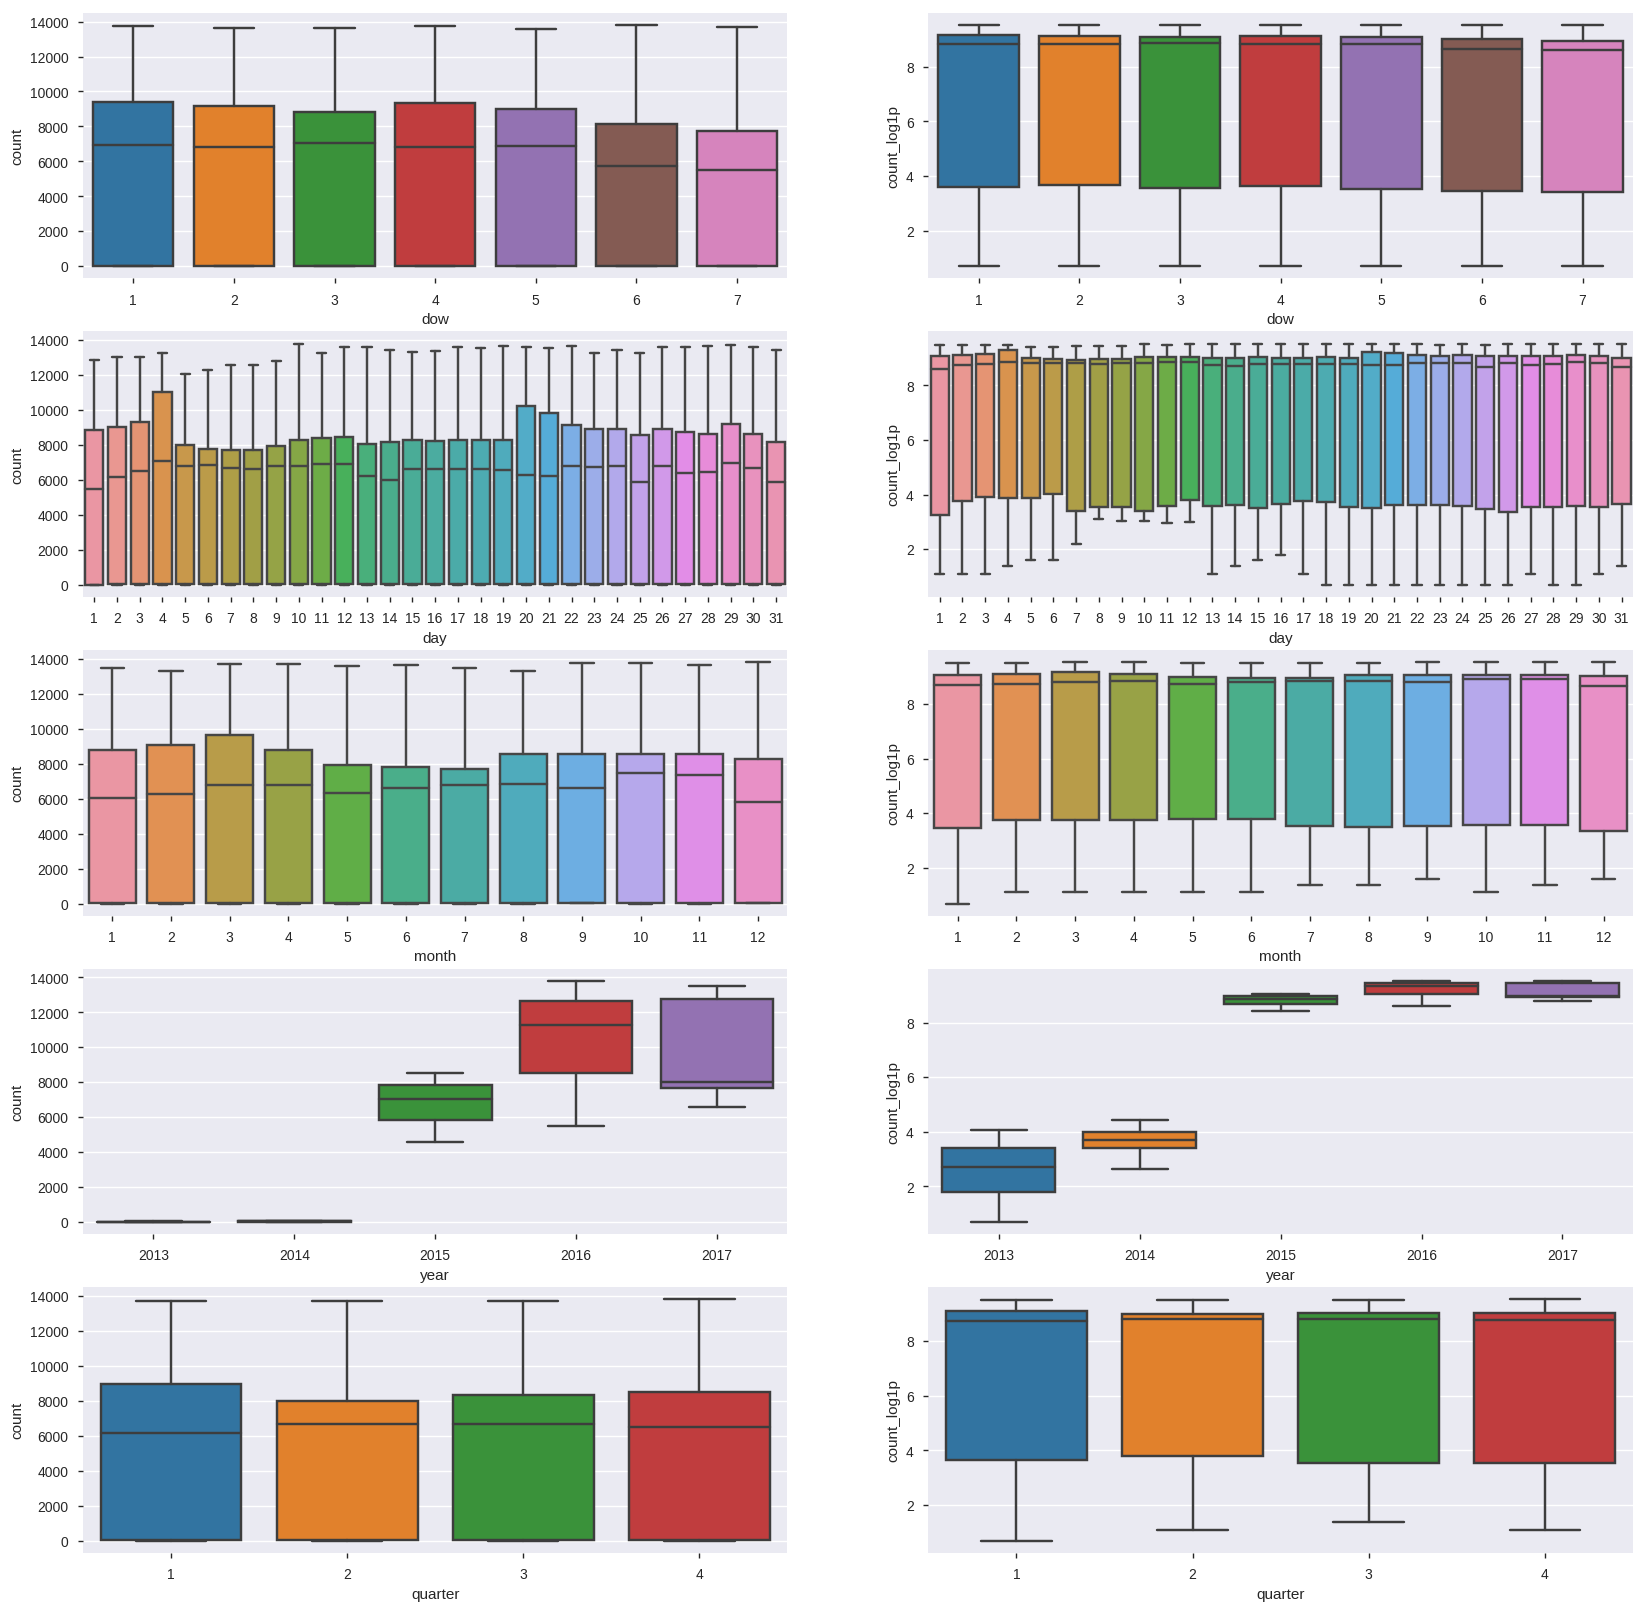

In [7]:
features = ['dow', 'day', 'month', 'year', 'quarter']
# time_features = df_data.columns.drop(['diff_count_log1p', 'count_log1p', 'count'])
fig, axes = plt.subplots(len(features), 2, figsize=(20, 20))
for i, f in enumerate(features):
    sns.boxplot(x=f, y='count', data=df_data, ax=axes[i][0])
    sns.boxplot(x=f, y='count_log1p', data=df_data, ax=axes[i][1])

### 2. Boxplotting Distribution of Quarters by Year

* In 2013 and 2016, first six months (two quarters) and last six months have different patterns.
* The quarters of 2015 and 2016 have same trend roughly however their total gains different
* The worker count is increasing on each quarter between 2015 - 2016
* The quarters of 2017 have different trends than the rest of year.

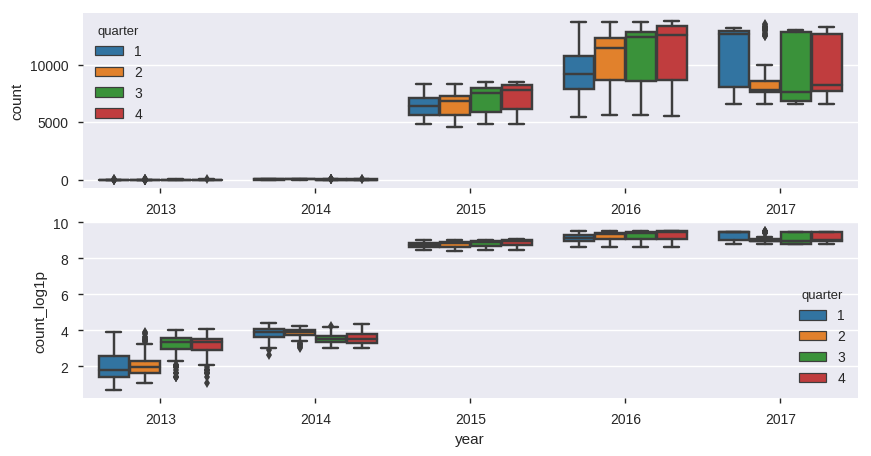

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
sns.boxplot(x='year', y='count', hue='quarter', data=df_data, ax=axes[0])    
sns.boxplot(x='year', y='count_log1p', hue='quarter', data=df_data, ax=axes[1])

### 3. Boxplotting Distribution of Years by Quarter

* In each quarter, data has same trend between 2013 and 2017

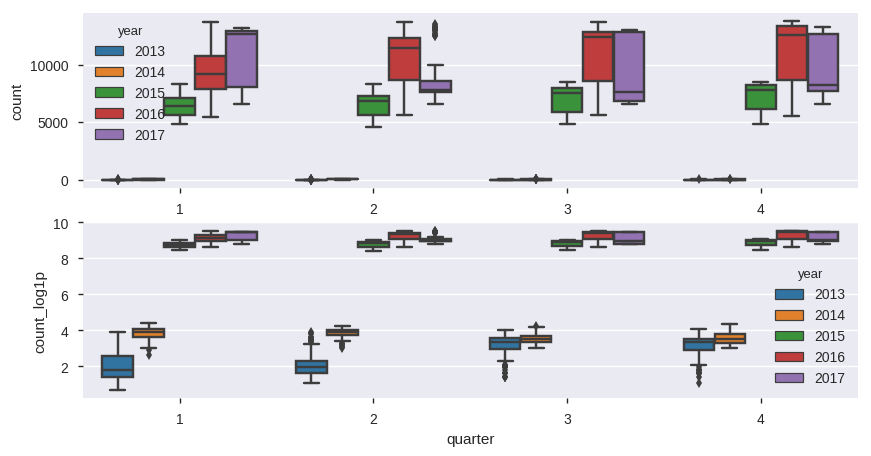

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
sns.boxplot(x='quarter', y='count', hue='year', data=df_data, ax=axes[0])
sns.boxplot(x='quarter', y='count_log1p', hue='year', data=df_data, ax=axes[1])

### 4. Boxplotting Distribution of Years by Month

* We can see 3 different patterns/trend on the plots, roughly:
    1. Between month 1st and 4th
    2. Between month 5th and 7th
    3. Between month 8th and 12th

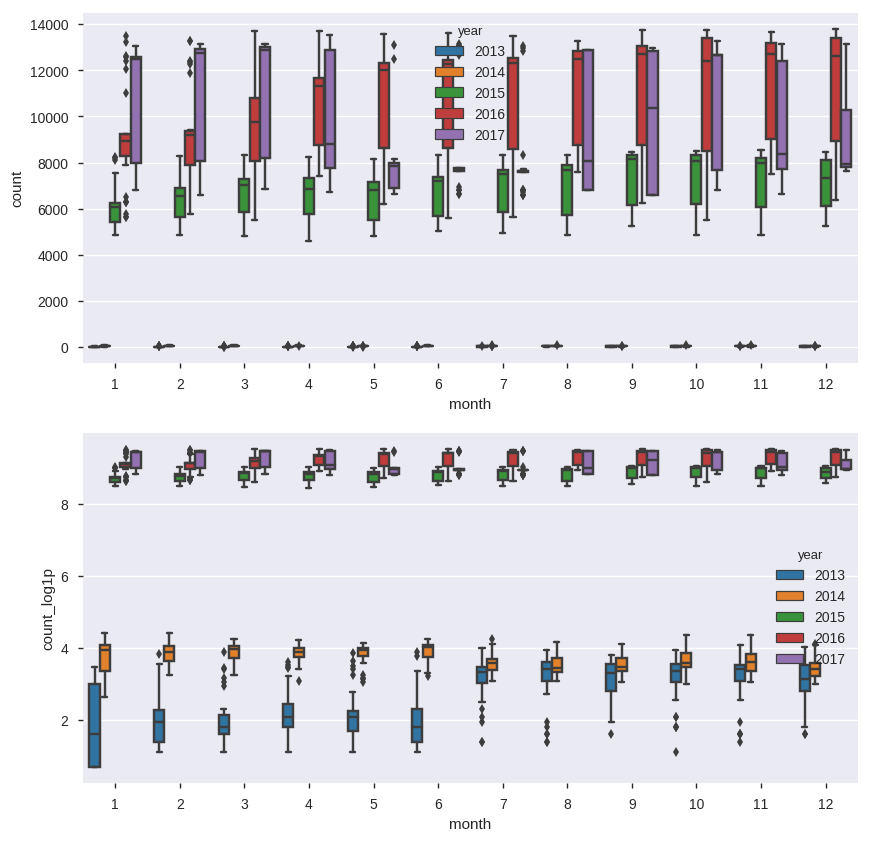

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.boxplot(x='month', y='count', hue='year', data=df_data, ax=axes[0])    
sns.boxplot(x='month', y='count_log1p', hue='year', data=df_data, ax=axes[1])

# Rolling Statistics
### 1. Rolling Statistics by Quarter (window = 90 days)

1. Trend: We can see on rolling average of worker count is growing over time according to our specific window. In our case, it is 90 days, which equeals to one quarter.

2. Seasonality: Employee's demands may have tendency to work with different number of employers in a particular time (e.g. month(s), week(s), day(s)) because of fulfill work.


According to plots, 1st order difference of logorithmic worker count has stationary shape since the moving mean and standart deviation have constant value along different year, 2013 - 2017. So, the parameter `d` = 1 can be useful at this point to move on our experiment.

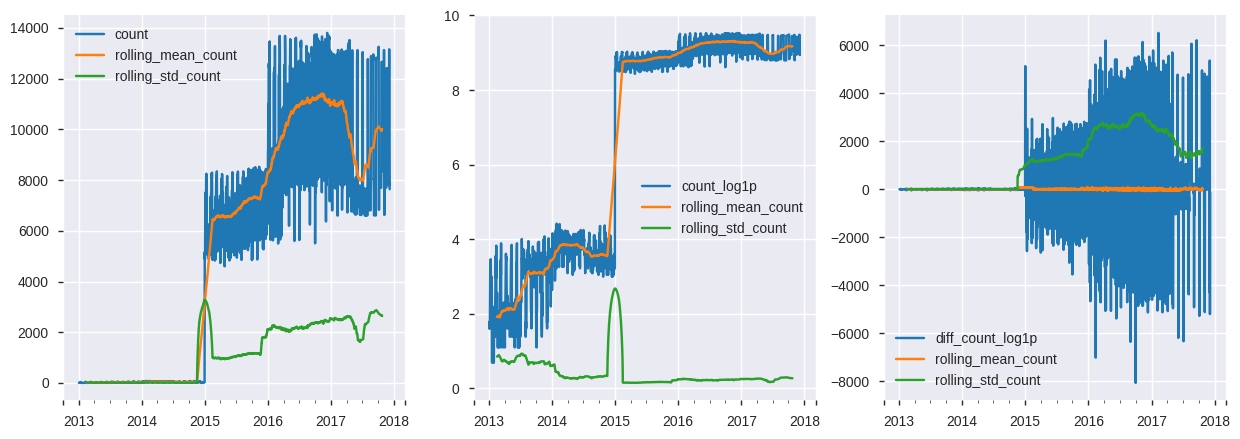

In [11]:
features = ['count', 'count_log1p', 'diff_count_log1p']

window = 90

fig, axes = plt.subplots(1, len(features), figsize=(15, 5))
for i, f in enumerate(features):
    df_tmp = df_data[[f]].copy()
    df_tmp['rolling_mean_count'] = df_tmp[f].rolling(window = window, center = True).mean()
    df_tmp['rolling_std_count'] = df_tmp[f].rolling(window = window, center = True).std()
    df_tmp.plot(ax = axes[i])

### 2. Rolling Statistics for Each Year by Monthly (window = 30 days)

In these plots, we can again see the difference of worker count has stationary shape on yearly analysis.

So, we can conclude that 1st order of difference of log. worker count is making our data stationary.

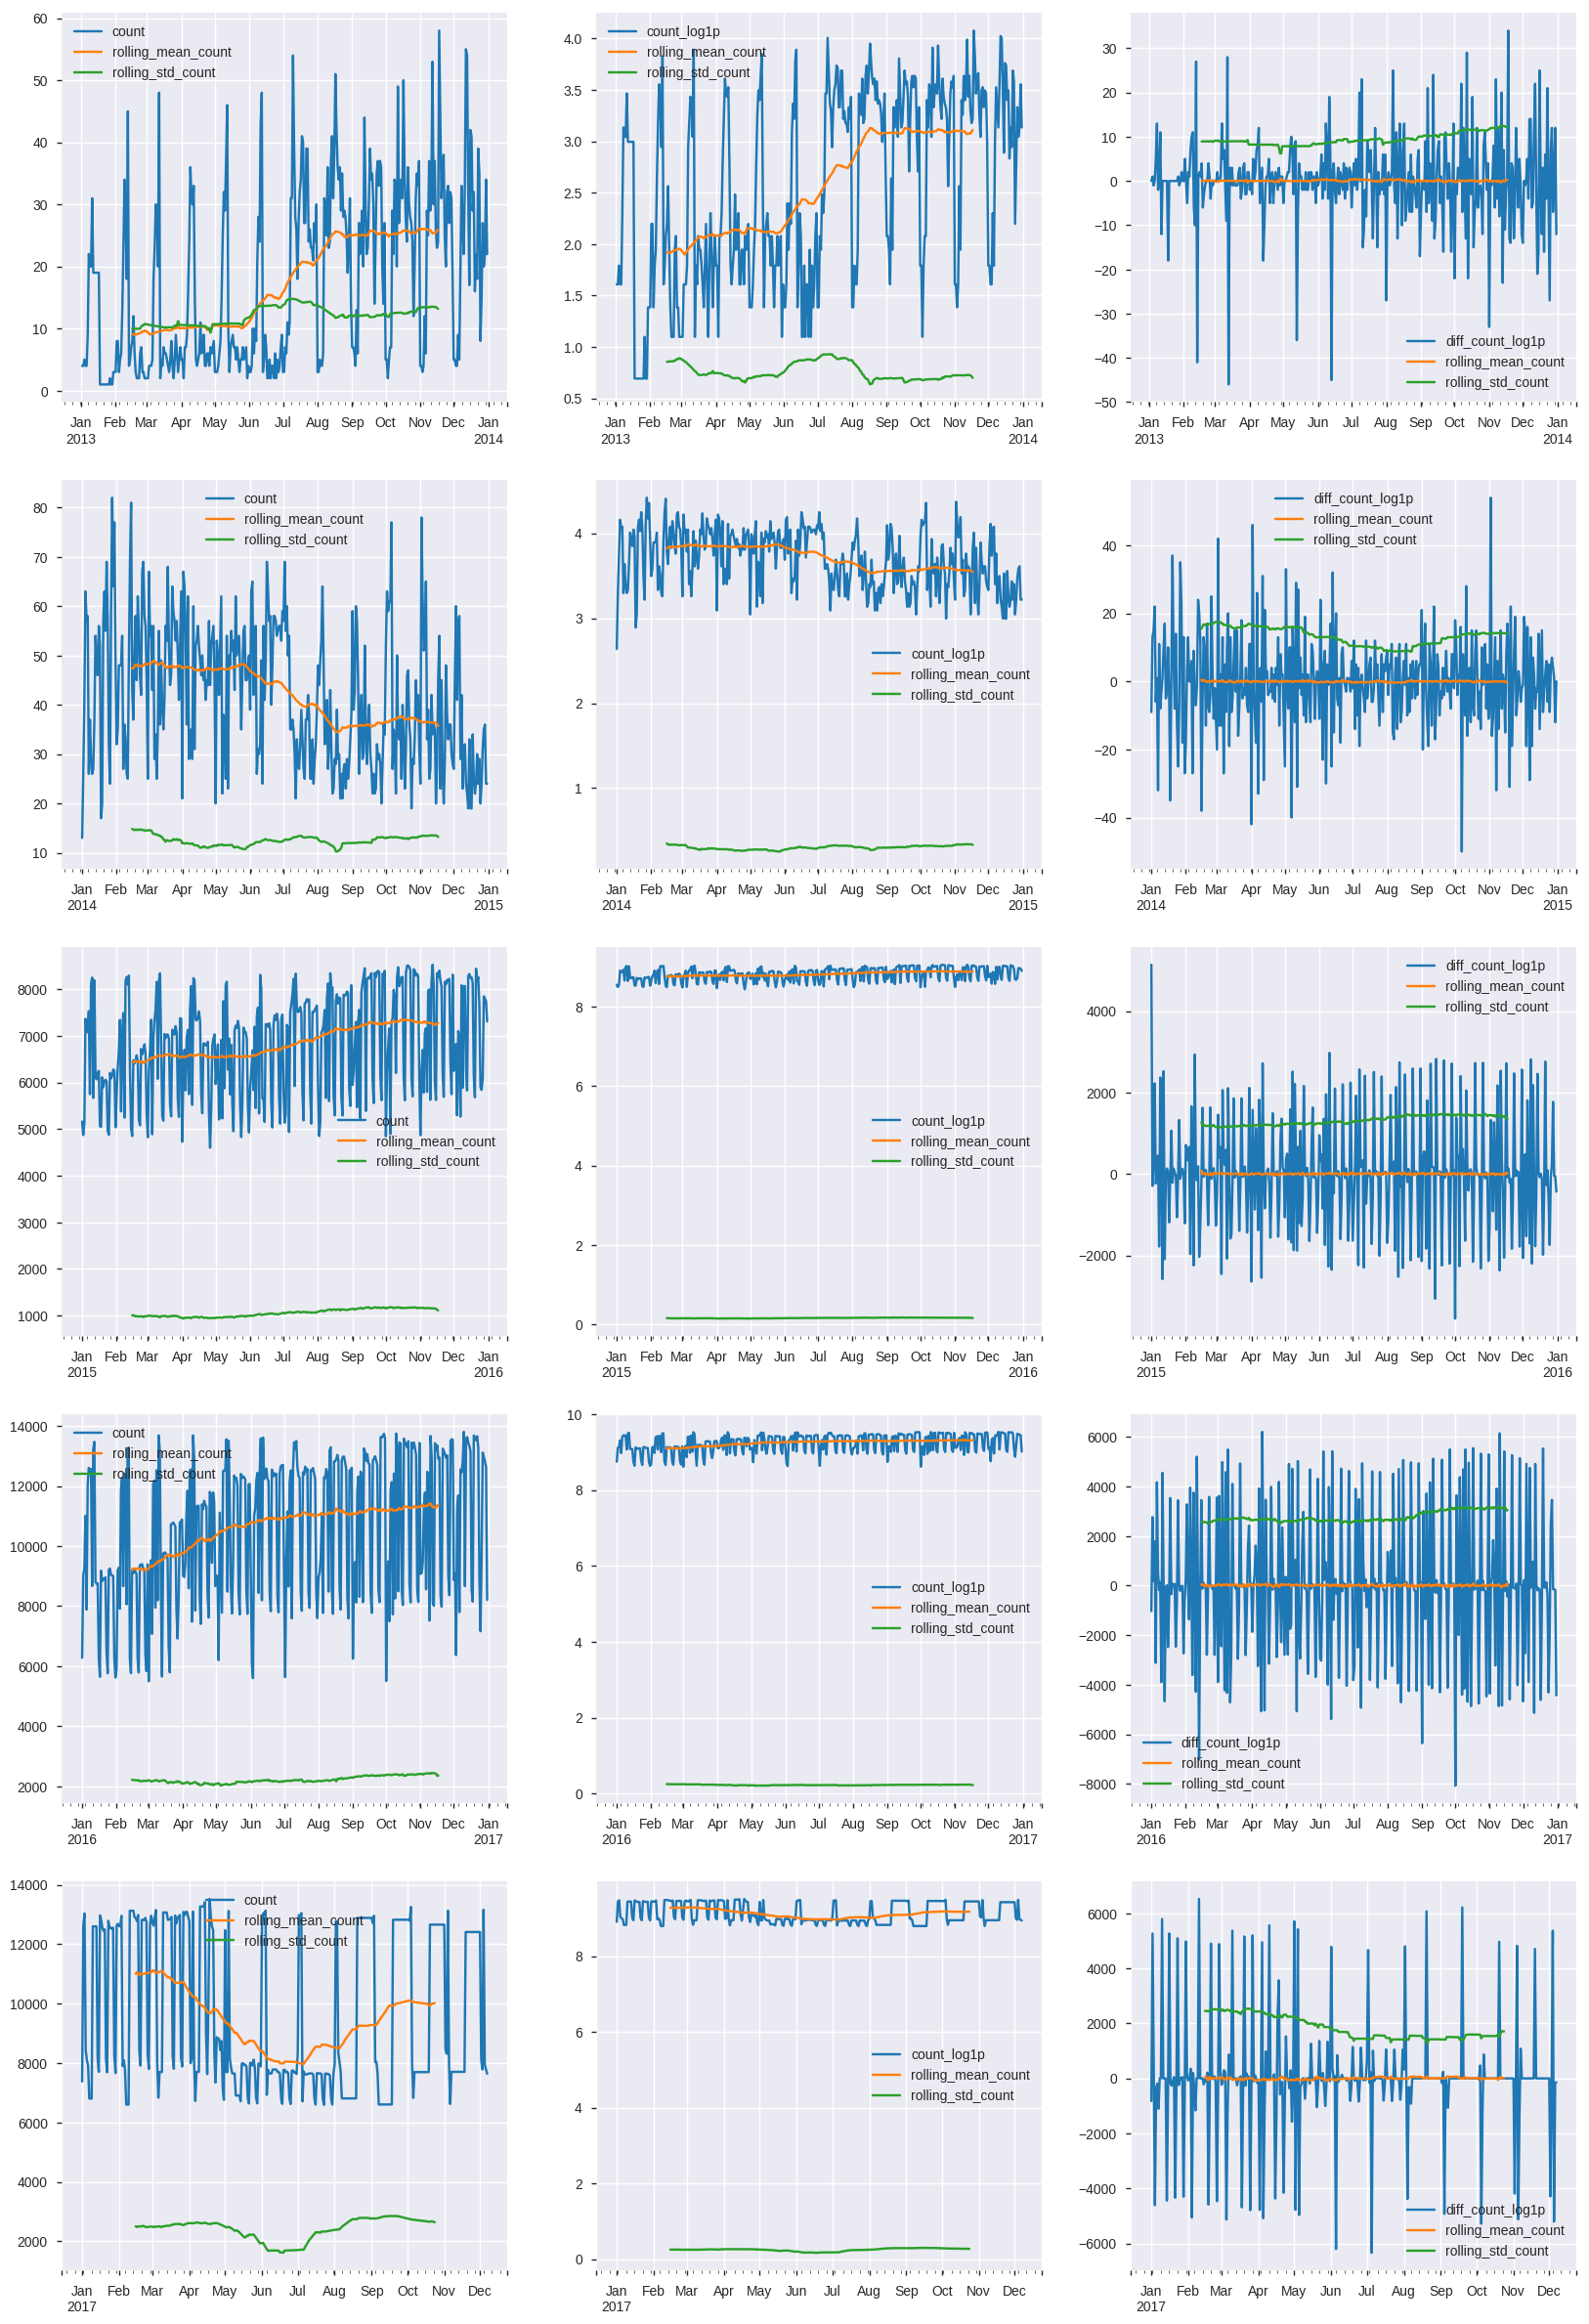

In [12]:
years = df_data['year'].unique()
features = ['count', 'count_log1p', 'diff_count_log1p']

window = 90

fig, axes = plt.subplots(len(years), len(features), figsize=(20, 30))
for i, y in enumerate(years):
    for j, f in enumerate(features):        
        df_tmp = df_data[df_data['year'] == y][[f]].copy()
        df_tmp['rolling_mean_count'] = df_tmp[f].rolling(window = window, center = True).mean()
        df_tmp['rolling_std_count'] = df_tmp[f].rolling(window = window, center = True).std()
        df_tmp.plot(ax=axes[i][j])

# Time Series Analysis (TSA)

* AR and MA = ARIMA (Non-Seasonal)
    1. To build a AR model, take a look at PACF on the features (`count`, `count_log1p`, `diff_count_log1p`) for a specific lag
    2. To build a MA model, take a look at ACF on the features (`count`, `count_log1p`, `diff_count_log1p`) for a specific lag



* SAR and MAR = SARIMAX = (Non-Seasonal) x (Seasonal)
    1. Aggregate data by quarter and year
    2. Apply PACF on the aggregated data for a SAR model
    3. Apply PAC on the aggregated data for a SMA model
    4. Pick the significant lags on PACF and PACF for a non-seasonal model (p,q)
    5. Look at the significance level of lags at k*S (in our cases, S is 4 corresponding to 4. k is 0,1,3)  
    
### Autocorrelation (ACF) and Partial Autocorrelation (PACF) of Time Series 

1. Even though ACF and PACF are being used to identify type of model either AR or MA, we can also use them to determine stationary of data whether or not. We can see data has non-stationary shape since ACF slowly goes down on the autocorrelation graph in 1st row plots of picture.

2. We may use either the log of worker count (`log_count1p`) or the difference of log of worker count (`diff_log_count1p`) features to obtaining more stationary shape since we already got rid of variation of data and trend.

    * The feature log_count1p will provide low variation data since it is reducing the variance of data
    * The feature diff_log_count1p will provide stationary data rougly since we got rid of some trend on data.

In the 3rd row plots of picture, we have a non-stationary data roughly since we could not see same patterns like the plots in the 1st row of picture. According to these plots, Order of AR may be p=3 since we see highly significant positive and negative correlations with the previous days at lag 3 on PACF plots. Order of MA may be q=6 because we can see correlation through lag 6th on ACF plots. The value of parameter d is 1 since we used 1st order of difference.

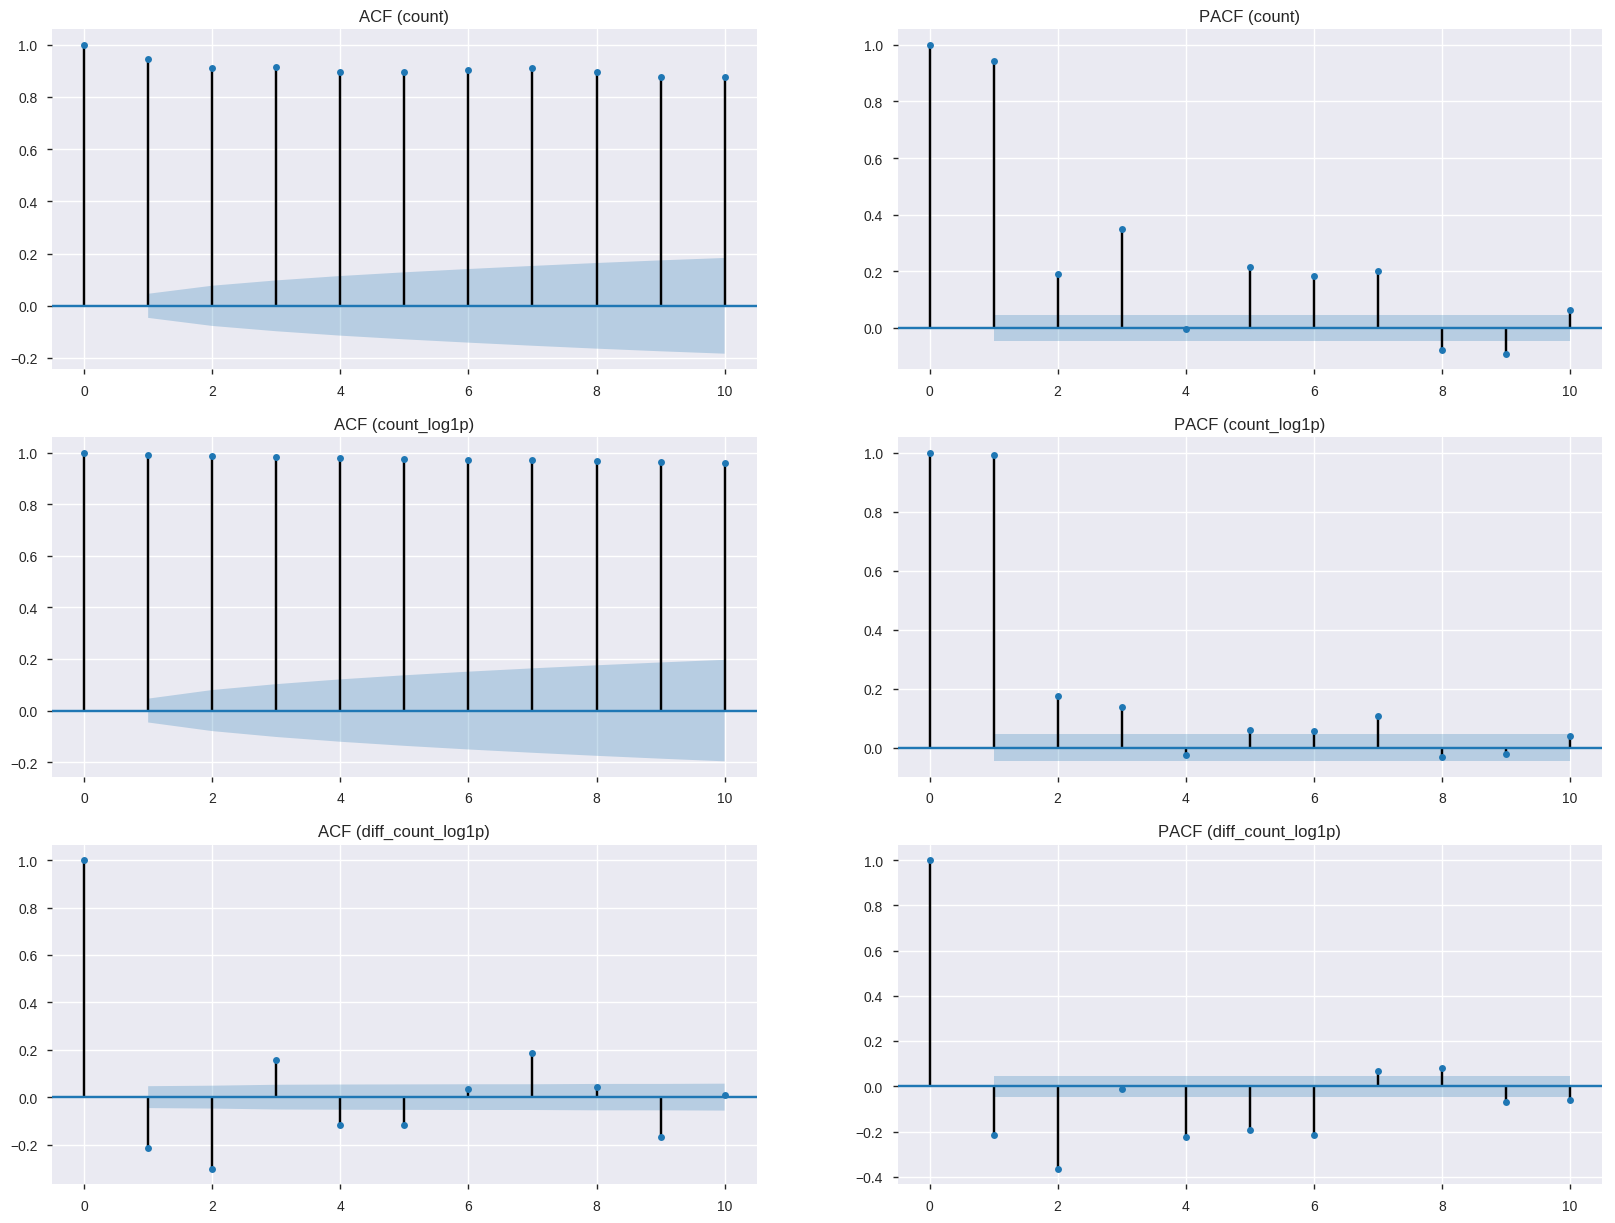

In [13]:
lags = 10
features = ['count', 'count_log1p', 'diff_count_log1p']

fig, axes = plt.subplots(len(features), 2, figsize=(20, 15))

for i, f in enumerate(features):
    
    df_tmp = df_data[f]
    
    # we are ignoring the first row since it is Nan value
    if f == 'diff_count_log1p':
        df_tmp = df_tmp.dropna()
        
    ax = sm.graphics.tsa.plot_acf(df_tmp, lags = lags, ax = axes[i][0], title='ACF ({})'.format(f))
    ax = sm.graphics.tsa.plot_pacf(df_tmp, lags = lags, ax = axes[i][1], title='PACF ({})'.format(f))

### 1.ARIMA

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Model (0, 0, 3) => MSE: 0.6968
Results of Dickey-Fuller Test:
Test Statistic                   -2.178921
p-value                           0.213985
#Lags Used                        5.000000
Number of Observations Used    1795.000000
Critical Value (1%)              -3.433998
Critical Value (10%)             -2.567628
Critical Value (5%)              -2.863152
dtype: float64
AIC: 4441.020870361617
--------------------------------------------------
Model (6, 0, 0) => MSE: 0.1324
Results of Dickey-Fuller Test:
Test Statistic                  -20.022539
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    1795.000000
Critical Value (1%)              -3.433998
Critical Value (10%)             -2.567628
Critical Value (5%)              -2.863152
dtype: float64
AIC: 1321.8298107956052
--------------------------------------------------


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model (5, 0, 3) => MSE: 0.1287
Results of Dickey-Fuller Test:
Test Statistic                -1.776197e+01
p-value                        3.335493e-30
#Lags Used                     5.000000e+00
Number of Observations Used    1.795000e+03
Critical Value (1%)           -3.433998e+00
Critical Value (10%)          -2.567628e+00
Critical Value (5%)           -2.863152e+00
dtype: float64
AIC: 1293.0862544055035
--------------------------------------------------


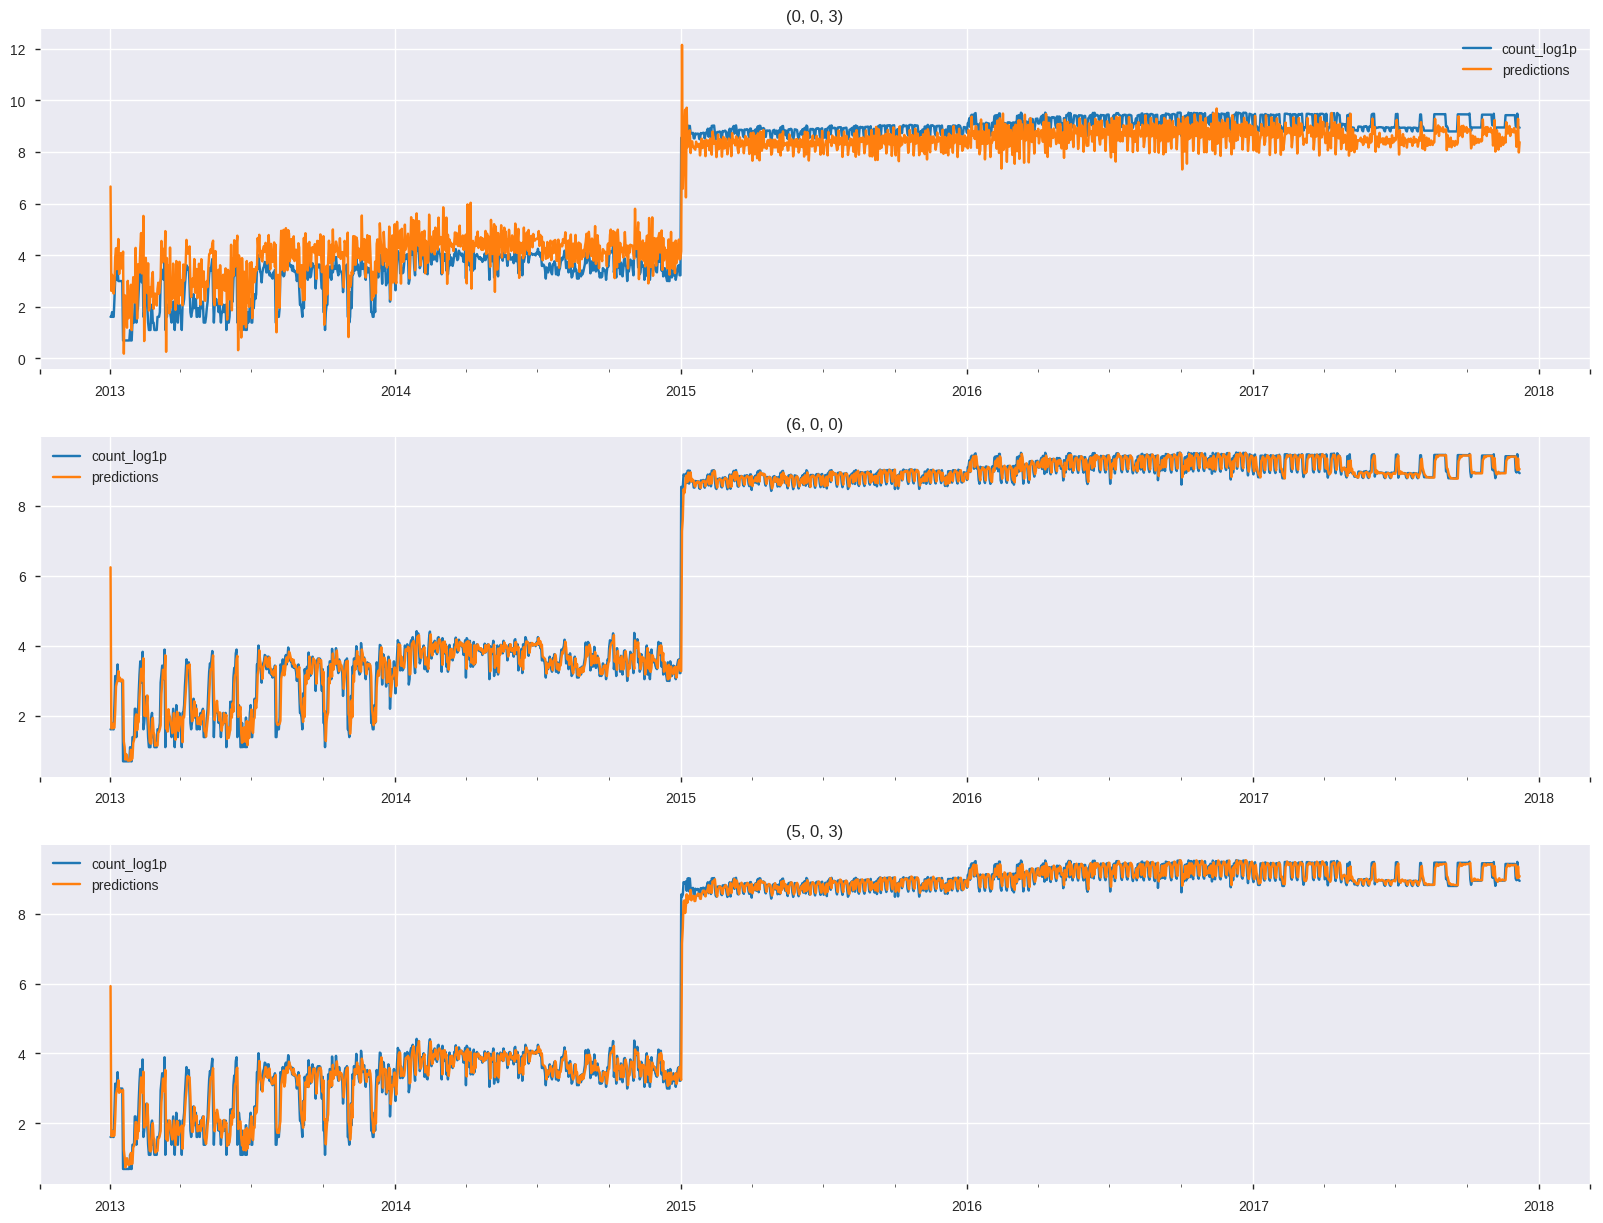

In [14]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

def adfuller(ts):

    print ('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(ts, autolag='AIC', maxlag=5) #erdi
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print( dfoutput)
    

def MSE(preds, actual, order):
    mse = mean_squared_error(preds, actual)
    print('Model', order, '=> MSE: %.4f'% mse)
    
def apply_ARIMA(df, f, models_parameters):
    
    l = len(models_parameters)
    
    fig, axes = plt.subplots(l, 1, figsize=(20, 5 * l))
    for i, order in enumerate(models_parameters):
        
        df_result = pd.DataFrame()
        df_result[f] = df[f].dropna()

        model = ARIMA(df_result[f], order=order)  
        predictions = model.fit(disp=-1)

        df_result['predictions'] = predictions.fittedvalues
        df_result[[f, 'predictions']].plot(title=str(order), ax = axes[i])

        MSE(df_result['predictions'].fillna(0), df_result[f],  str(order))
        resid = df_result['predictions'].fillna(0) - df_result[f]
        adfuller(resid)
        
        print('AIC:', predictions.aic)

        print(50*'-')

    
models_parameters = [
    (0, 0, 3), # MA(3)
    (6, 0, 0), # AR(6)
    (5, 0, 3)
]
    
apply_ARIMA(df_data, 'count_log1p', models_parameters)

### TS Decomposition
In this step, we decomposed our data into 3 components rather using rolling statistic.
    1. Seasonal
    2. Trend
    3. Residual
    
According to residual plots, TS decomposition is working well to build a model for non-seasonal behavior. However,
we can improve that result by using SARIMAX when we take seasonal effect into account. In PACF of residual result, we  observe significant correlation from lag 0 through lag 10 on the plot. To make the residual data more stationary than current, we need to model seasonal effect, as well.

Results of Dickey-Fuller Test:
Test Statistic                -1.145711e+01
p-value                        5.671215e-21
#Lags Used                     3.000000e+00
Number of Observations Used    1.706000e+03
Critical Value (1%)           -3.434189e+00
Critical Value (10%)          -2.567673e+00
Critical Value (5%)           -2.863236e+00
dtype: float64


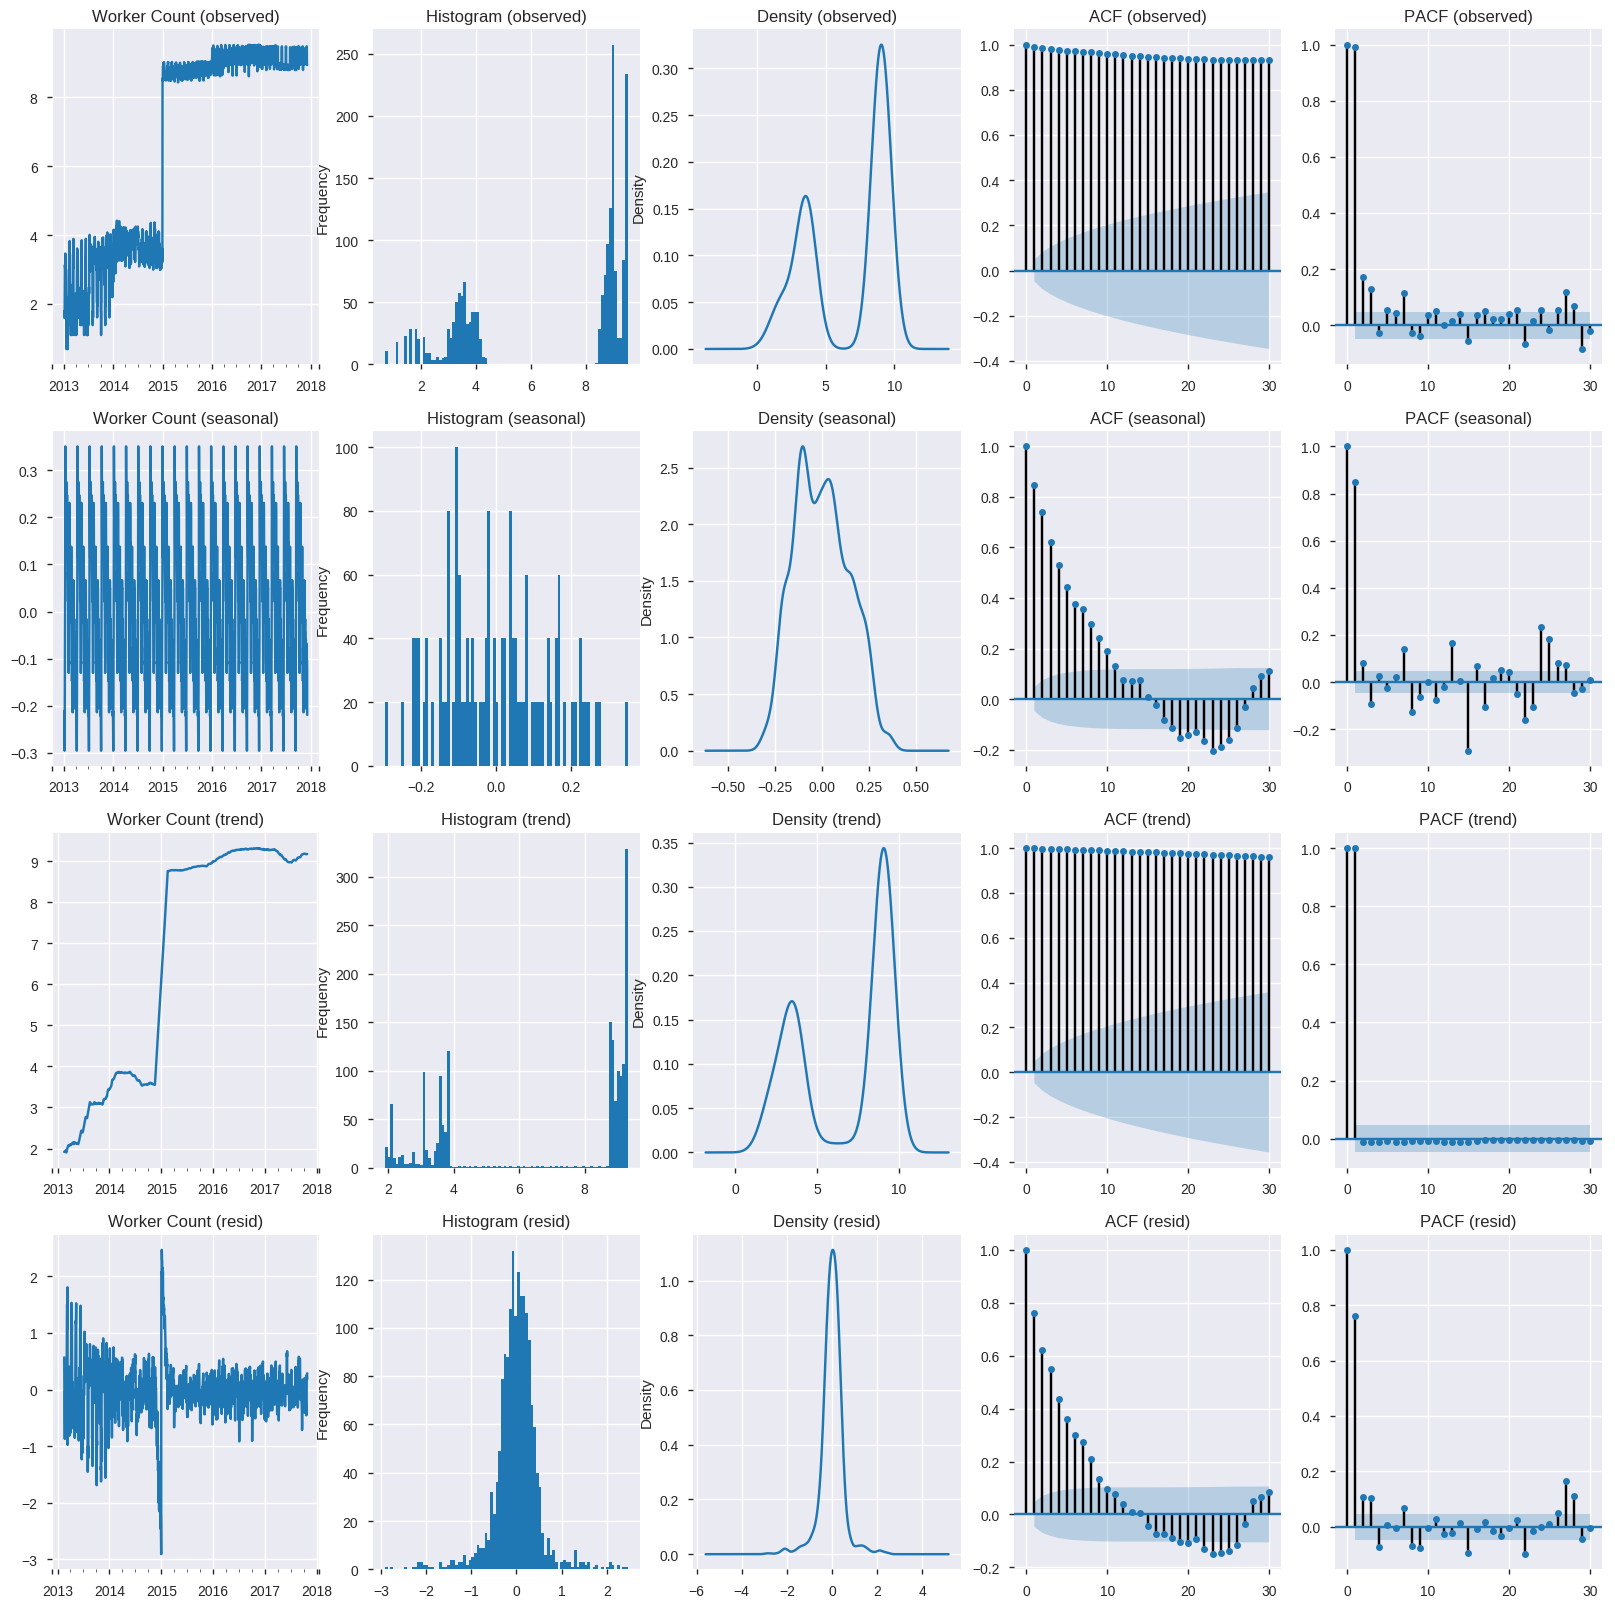

In [15]:
freq = 90
phase = int(freq / 2)
lags = 30

decomposition = sm.tsa.seasonal_decompose(df_data['count_log1p'].iloc[1:], model='additive', freq = freq)

df_decom = pd.DataFrame()
df_decom['observed'] = decomposition.observed
df_decom['seasonal'] = decomposition.seasonal
df_decom['trend'] = decomposition.trend
df_decom['resid'] = decomposition.resid

fig, axes = plt.subplots(4, 5, figsize=(20, 20))
for i, f in enumerate(df_decom.columns):
    df_decom[f].plot(ax = axes[i][0], title='Worker Count ({})'.format(f))
    df_decom[f].plot.hist(bins=freq, ax = axes[i][1], title='Histogram ({})'.format(f))
    df_decom[f].plot.density(ax = axes[i][2], title='Density ({})'.format(f))

    ax = sm.graphics.tsa.plot_acf(df_decom[f].iloc[phase:-phase], lags = lags, ax = axes[i][3], title='ACF ({})'.format(f))
    ax = sm.graphics.tsa.plot_pacf(df_decom[f].iloc[phase:-phase], lags = lags, ax = axes[i][4], title='PACF ({})'.format(f))
    

adfuller(df_decom['resid'].iloc[phase:-phase])

### 2. SARIMAX

* SAR and MAR = SARIMAX = (Non-Seasonal) x (Seasonal)
    1. Aggregate data by quarter and year
    2. Apply PACF on the aggregated data for a SAR model
    3. Apply PAC on the aggregated data for a SMA model
    4. Pick the significant lags on PACF and PACF for a non-seasonal model (p,q)
    5. Look at the significance level of lags at k*S (in our cases, S is 4 corresponding to 4. k is 0,1,3

To model a seasonal effect, we use quarterly worker count data which were aggreated by quarter and year over our orginal data.

According to ACF and PACF plots, there is no seasonal effect on each quarter at lag 4,8 and 12
So, P and Q could be picked as 0. 

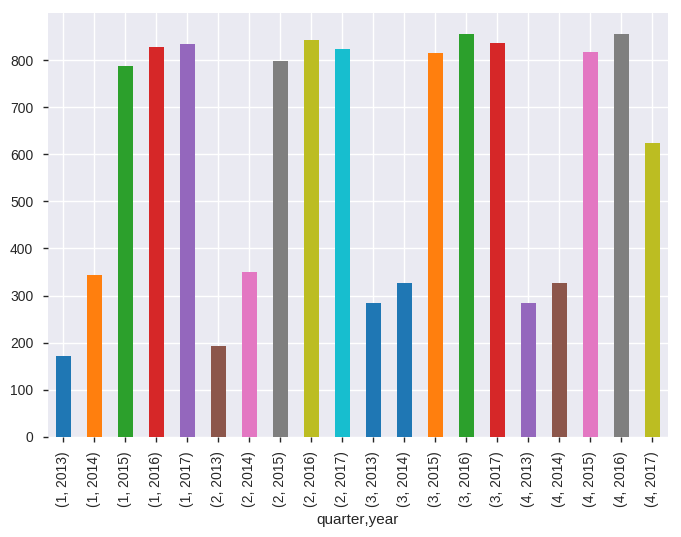

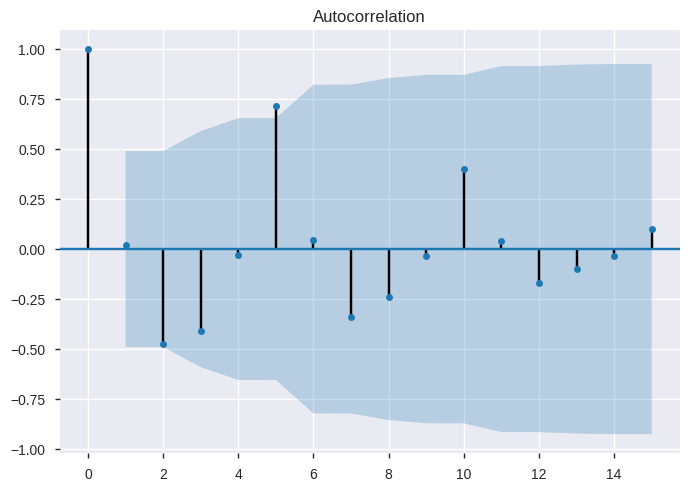

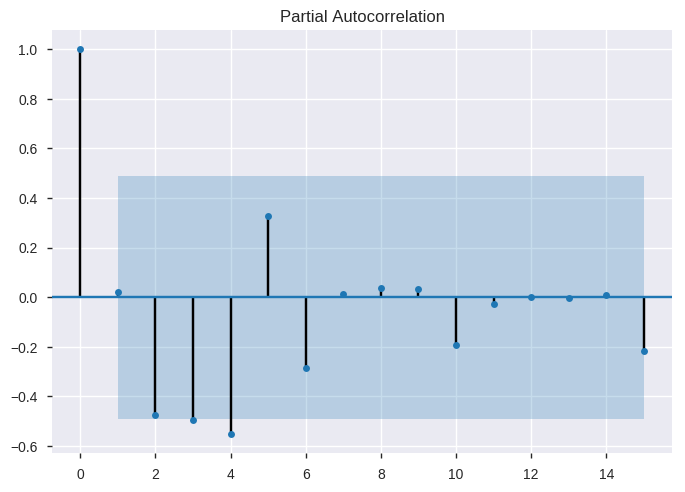

In [16]:
df_tmp = df_data[['year', 'quarter', 'count_log1p', 'count']].groupby(['quarter', 'year']).aggregate({
    'count_log1p': ['sum', 'mean'],
    'count' : ['sum', 'mean']
})

df_tmp[('count_log1p', 'sum')].plot.bar()

s = 4
c = df_tmp[('count_log1p', 'sum')].shift(s) - df_tmp[('count_log1p', 'sum')]
ax = sm.graphics.tsa.plot_acf(c.iloc[s:].values, lags= 15)
ax = sm.graphics.tsa.plot_pacf(c.iloc[s:].values, lags= 15)

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model (1, 0, 1)(0, 0, 0, 4) => MSE: 0.1237
Results of Dickey-Fuller Test:
Test Statistic                  -19.811438
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    1795.000000
Critical Value (1%)              -3.433998
Critical Value (10%)             -2.567628
Critical Value (5%)              -2.863152
dtype: float64
AIC: 1336.67273701939


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:            count_log1p   No. Observations:                 1801
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -663.336
Date:                Sat, 19 May 2018   AIC                           1336.673
Time:                        05:10:48   BIC                           1364.153
Sample:                    01-02-2013   HQIC                          1346.817
                         - 12-07-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0610      0.015      4.101      0.000       0.032       0.090
drift          0.0001   4.08e-05      2.739      0.006    3.18e-05       0.000
ar.L1          0.9764      0.007    140.238      0.000       0.963       0.990
ma.L1         -0.2229      0.015    -14.454      0.000      -0.253      -0.193
sigma2         0.1224      0.001     87.621      0.000       0.120       0.125
===================================================================================
Ljung-Box (Q):                      299.53   Jarque-Bera (JB):             85307.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

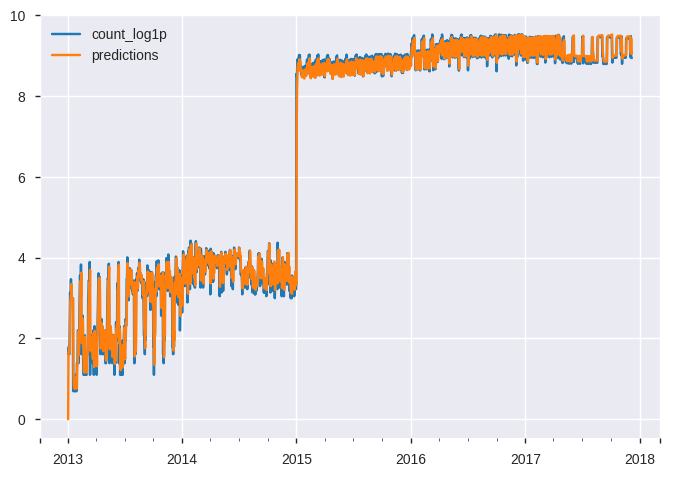

In [17]:
def apply_SARIMAX(df, f, order, seasonal_order):
    model = sm.tsa.statespace.SARIMAX(df[f], 
                                      trend='ct', 
                                      order=order, 
                                      seasonal_order=seasonal_order, 
                                      enforce_invertibility=False,
                                      enforce_stationarity=False)
    predictions = model.fit()
    
    df_result = pd.DataFrame()
    df_result[f] = df_data[f]

    df_result['predictions'] = predictions.fittedvalues
    df_result[[f, 'predictions']].plot()
    
    MSE(df_result['predictions'].fillna(0), df_data[f], str(order)+str(seasonal_order))
    
    resid = df_result['predictions'].fillna(0) - df_data[f]
    adfuller(resid)
    
    print('AIC:', predictions.aic)
    display(predictions.summary())
    
    return predictions

# (0,0,0) is not applicable for algo so we revised it as (1,0,1)
predictions = apply_SARIMAX(df_data, 'count_log1p', order=(1,0,1), seasonal_order=(0,0,0,4))

# Evaluation 

In the top right plot, we see that KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The residuals over time (top left plot) don't have any obvious seasonality and appear since we could not see any effect seasonality on autocorrelation plot.

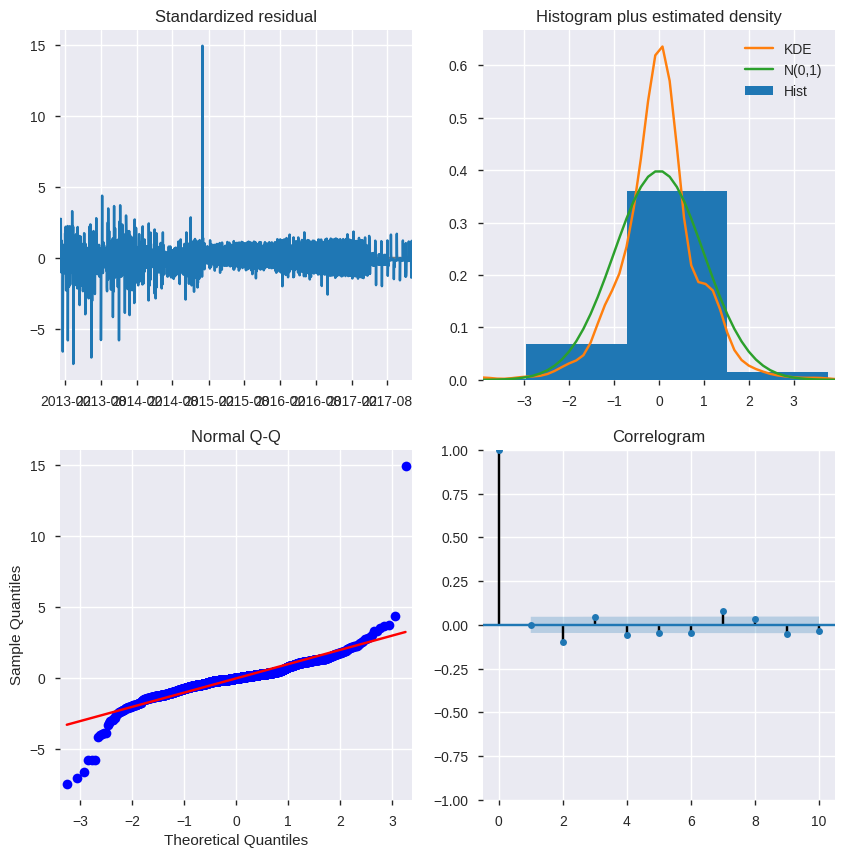

In [18]:
predictions.plot_diagnostics(figsize=(10, 10))
plt.show()

# Prediction 

Predict worker counts from '2017-05-01' to the last date in data

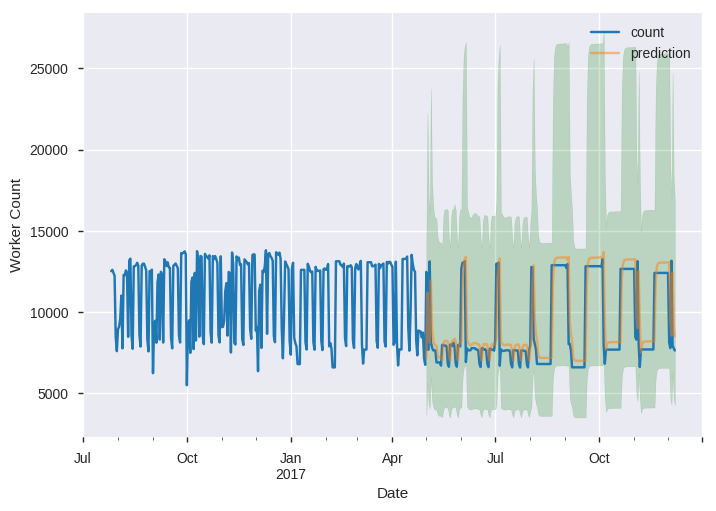

In [19]:
pred = predictions.get_prediction(start=pd.to_datetime('2017-05-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = df_data[['count']]['2015':][-500:].plot(label='observed')
pred.predicted_mean.apply(np.expm1).plot(ax=ax, label='prediction', alpha=.5)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0].apply(np.expm1),
                pred_ci.iloc[:, 1].apply(np.expm1), color='g', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Worker Count')
plt.legend()
plt.show()

# Forecasting 

Forecast 5 consecutive days in future using SARIMAX model

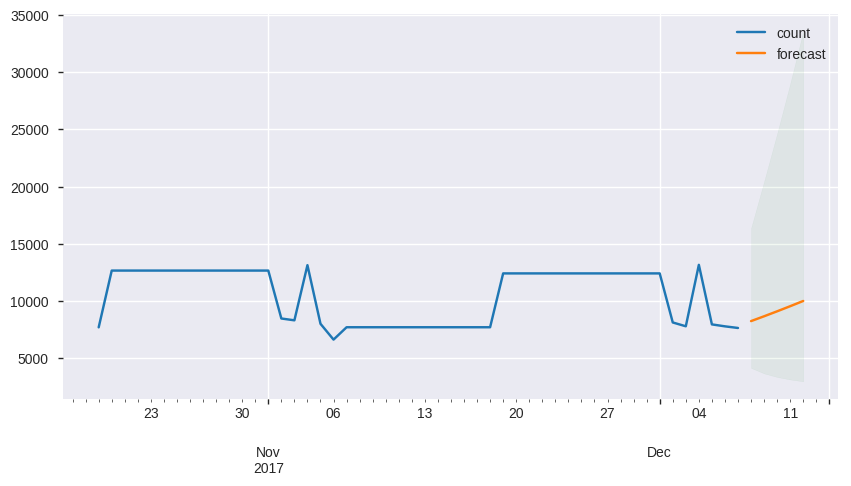

In [20]:
pred_uc = predictions.get_forecast(steps=5)

# # Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()


ax = df_data[['count']][-50:].plot(label='observed', figsize=(10, 5))

pred_uc.predicted_mean.apply(np.expm1).plot(ax=ax, label='forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0].apply(np.expm1),
                pred_ci.iloc[:, 1].apply(np.expm1), color='g', alpha=.05)

plt.legend()
plt.show()

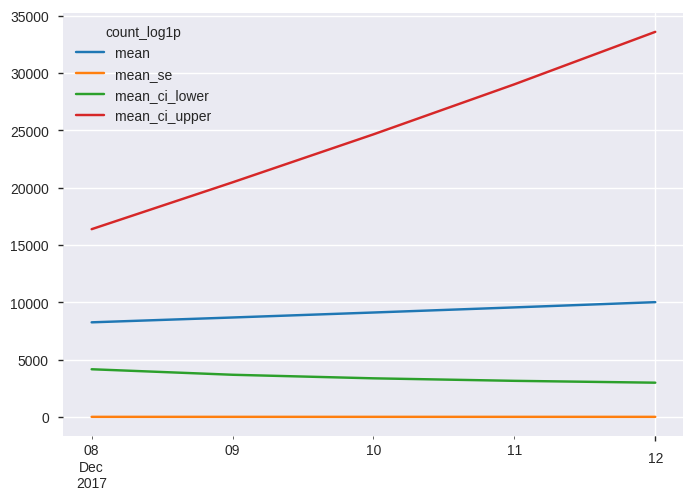

In [21]:
df_forecast = pred_uc.summary_frame().apply(np.expm1)
df_forecast.plot()